In [1]:
from torchdyn.models import *
from torchdyn.datasets import *
from torchdyn import *

In [2]:
from torch.autograd import grad
from torch import nn
import torch

class LNN(nn.Module):
    def __init__(self, L):
        super().__init__()
        self.L = L # model
    
    def forward(self, x):
        with torch.set_grad_enabled(True):
            self.n = n = x.shape[1]//2 # x (bs, 2D) D in q dim
            qqd = x.requires_grad_(True) # [bs, q qd]
            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0]
            DL_q, DL_qd = J[:, :n], J[:, n:]
            DDL_qd = [] #hessian
            for i in range(n):
                J_qd_i = DL_qd[:, i][:, None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:]) # (bs, q, qd) * (bs, qd)
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T)

        return torch.cat([qqd[:,self.n:], qdd], 1)

    def _lagrangian(self, qqd):
        return self.L(qqd)

In [3]:
class ControlledLNN(nn.Module):
    def __init__(self, L, x_dim, input_matrix = nn.Identity()):
        super().__init__()
        self.L = L # model
        self.x_dim = x_dim
        self.input_matrix = input_matrix
        self.input_matrix.requires_grad_(False)        
    
    def forward(self, xu):
        with torch.set_grad_enabled(True):
            self.n = n = self.x_dim // 2  # x (bs, 2D) D in q dim
            xu = xu.requires_grad_(True)

            qqd = xu[:, :self.x_dim]
            u = xu[:, self.x_dim:]

            L = self._lagrangian(qqd).sum()
            J = grad(L, qqd, create_graph=True)[0]
            DL_q, DL_qd = J[:, :n], J[:, n:]
            DDL_qd = [] #hessian
            for i in range(n):
                J_qd_i = DL_qd[:, i][:, None]
                H_i = grad(J_qd_i.sum(), qqd, create_graph=True)[0][:,:,None]
                DDL_qd.append(H_i)
            DDL_qd = torch.cat(DDL_qd, 2)
            DDL_qqd, DDL_qdqd = DDL_qd[:,:n,:], DDL_qd[:,n:,:]
            
            T = torch.einsum('ijk, ij -> ik', DDL_qqd, qqd[:,n:]) # (bs, q, qd) * (bs, qd)
            qdd = torch.einsum('ijk, ij -> ik', DDL_qdqd.inverse(), DL_q - T - self.input_matrix(u))

        return torch.cat([qqd[:,self.n:], qdd, torch.zeros_like(u)], 1)

    def _lagrangian(self, qqd):
        return self.L(qqd)

In [18]:
import torch.utils.data as data
device = torch.device("cpu")

m, k, l = 1, 1, 1

dataset = 100 * 1000  

X = torch.Tensor(dataset, 1).uniform_(-1, 1).to(device)
dX = torch.zeros_like(X)
U = torch.Tensor(dataset, 1).uniform_(-0.1, 0.1).to(device)
Xdd = -k*X/m + U

X_Xd_U = torch.cat([X, dX, U], axis=1)
Xd_Xdd_dU = torch.cat([dX, Xdd, torch.zeros_like(U)], axis=1)
train = data.TensorDataset(X_Xd_U, Xd_Xdd_dU)
trainloader = data.DataLoader(train, batch_size=64, shuffle=False, num_workers=8)

print(X_Xd_U)
print(Xd_Xdd_dU.shape)
# print(XdXddU.shape)


tensor([[-0.1115,  0.0000, -0.0302],
        [ 0.0715,  0.0000,  0.0474],
        [-0.6729,  0.0000,  0.0628],
        ...,
        [-0.5158,  0.0000,  0.0310],
        [-0.7296,  0.0000, -0.0815],
        [-0.1054,  0.0000,  0.0276]])
torch.Size([100000, 3])


In [19]:
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model

    def forward(self, x):
        return self.model.defunc(0, x)

    def loss(self, y_hat, y): # predict, target
        return ((y - y_hat)**2).mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model.defunc(0, x) #static training: we do not solve the ODE
        loss = self.loss(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

In [20]:
# hdim = 128
# net = LNN(nn.Sequential(
#             nn.Linear(2,hdim),
#             nn.Softplus(),
#             nn.Linear(hdim,hdim),
#             nn.Softplus(),
#             nn.Linear(hdim,1))
#          ).to(device)

hdim = 128
net = ControlledLNN(
            nn.Sequential(
            nn.Linear(2,hdim),
            nn.Softplus(),
            nn.Linear(hdim,hdim),
            nn.Softplus(),
            nn.Linear(hdim,1)),
            2,
         ).to(device)

model = NeuralDE(func=net, solver='dopri5').to(device)

In [21]:

learn = Learner(model)
trainer = pl.Trainer(max_epochs=10)
trainer.fit(learn)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores

  | Name  | Type     | Params
-----------------------------------
0 | model | NeuralDE | 17.0 K
-----------------------------------
17.0 K    Trainable params
0         Non-trainable params
17.0 K    Total params
0.068     Total estimated model params size (MB)
Epoch 5:  14%|█▍        | 223/1563 [00:04<00:28, 47.55it/s, loss=4.22e-05, v_num=20]

In [40]:
import time
t = time.time()
model.nfe = 0
X0 = torch.Tensor(256, 2).uniform_(-1,1).to(device)
zero_force = -0.4*torch.ones(256, 1)

XU0 = torch.cat([X0, zero_force], axis=1)

s_span = torch.linspace(0, 1, 10)
traj = model.trajectory(XU0, s_span).cpu().detach()
T = time.time() - t
print(f"NFE: {model.nfe}\ninference time: {T}\navg time per function evaluation: {T/model.nfe}")

NFE: 20
inference time: 0.0836336612701416
avg time per function evaluation: 0.00418168306350708


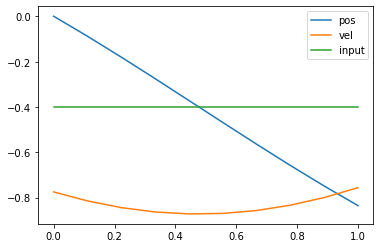

In [41]:
from scipy.integrate import odeint
index = 10

def mass_spring(xu, t):
    x, dx, u = np.split(xu, 3)
    m, k, l = 1, 1, 1
    ddx = -k*x/m + u/m

    return np.hstack([dx, ddx, np.zeros_like(u)])


sol = odeint(mass_spring, XU0.detach().numpy()[index], s_span.detach().numpy())
plt.plot(s_span, sol[:, 0])
plt.plot(s_span, sol[:, 1])
plt.plot(s_span, sol[:, 2])
plt.legend(["pos", "vel", "input"])
plt.show()

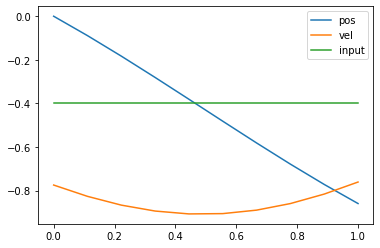

In [42]:
plt.plot(s_span, traj[:, index, 0])
plt.plot(s_span, traj[:, index, 1])
plt.plot(s_span, traj[:, index, 2])
plt.legend(["pos", "vel", "input"])
plt.show()
